# Kaggle Challenge: Image Recognition - Gender Detection - Inceptionv3

**Challenge**: 

Using Deep Learning build a model to predict whether a face is male or female.

**Background**:

Image recognisiton is one of the many applications of Machine Learning, it can sove problems for security purposes, object detection, face detection, healthcare, entertainment, and many more. This application has enormous potenial to help our society, so it is importnant to find new uses for this tool, improve the current methods and get more accuract and useful insights from it.

**Dataset**

Using the CelebA dataset, available from kaggle. This dataset was originally collected by researchers at MMLAB, The Chinese University of HK and is composed of 202599 images of 10177 unique celebrities, but names of identities are not given 40 binary attribute annotations per image 5 landmark locations. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

# keras imports

import tensorflow as tf
from tensorflow import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

## Import the data and Explore

In [2]:
# data saved to a folder named ImageRecgonition

# set variables

main_folder = '/Users/georgebrockman/code/georgebrockman/Autoenhance.ai/ImageRecognition/'
images_folder = main_folder + 'img_align_celeba/'

EXAMPLE_PIC = images_folder + '000606.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLE = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [3]:
# Load the attributes of every image

# create a DataFrame from the CSV
attr_df = pd.read_csv(main_folder + 'list_attr_celeba.csv')
# reset indexs to image_id
attr_df.set_index('image_id', inplace=True)
# Replace the value of -1 with 0
attr_df.replace(to_replace=-1, value=0, inplace=True)
# show shape
attr_df.shape

(202599, 40)

In [4]:
# Show attributes
attributes = attr_df.columns
attributes

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [5]:
# list of the attributes in CelebA dataset

# use a forloop and enumarate through attributes
for i, j in enumerate(attributes):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


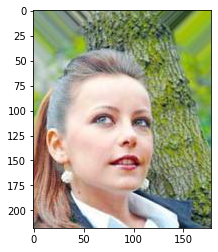

In [6]:
# Show an example picture from the dataset

img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)

In [7]:
# show some attributes of the example figure

# split by the / to remove and then take the last value using -1
# choose some attributes from the list above to check
attr_df.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling', 'Straight_Hair', 'No_Beard', 'Double_Chin']]

Smiling          0
Straight_Hair    0
No_Beard         1
Double_Chin      0
Name: 000606.jpg, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

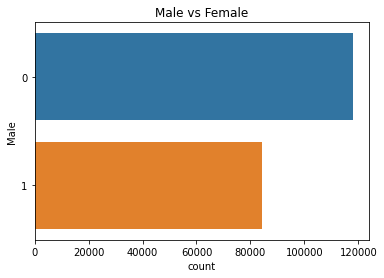

In [8]:
# Distribution of the Attributes

# Male vs Female

plt.title('Male vs Female')
sns.countplot(y='Male', data=attr_df)
plt.show


## Split Dataset into Training, Test and Validation Sets

Due to the size of the file, we are only going to use 20000 images in the training, and 5000 in both test and validation.

In [9]:
part_df = pd.read_csv(main_folder+'list_eval_partition.csv')
# 0 -> Training
# 1 -> Validation
# 2 -> Test

# check
part_df.tail()

,image_id,partition
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2
202598,202599.jpg,2


In [10]:
# show counts
part_df['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [11]:
# Add the attributes to the table

part_df.set_index('image_id', inplace=True)
# use an inner join to create the new table from the two DataFrames already created
pattr_df = part_df.join(attr_df['Male'], how='inner')
pattr_df.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [12]:
# Balance the datasets for training 

def load_reshape_img(fname):
    img = load_img(fname)
    # normalise pixel array
    x = img_to_array(img)/255.
    # reshape
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = pattr_df[(pattr_df['partition'] == partition) 
                           & (pattr_df[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      pattr_df[(pattr_df['partition'] == partition) 
                                  & (pattr_df[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Pre-processing images: Data Augmentation

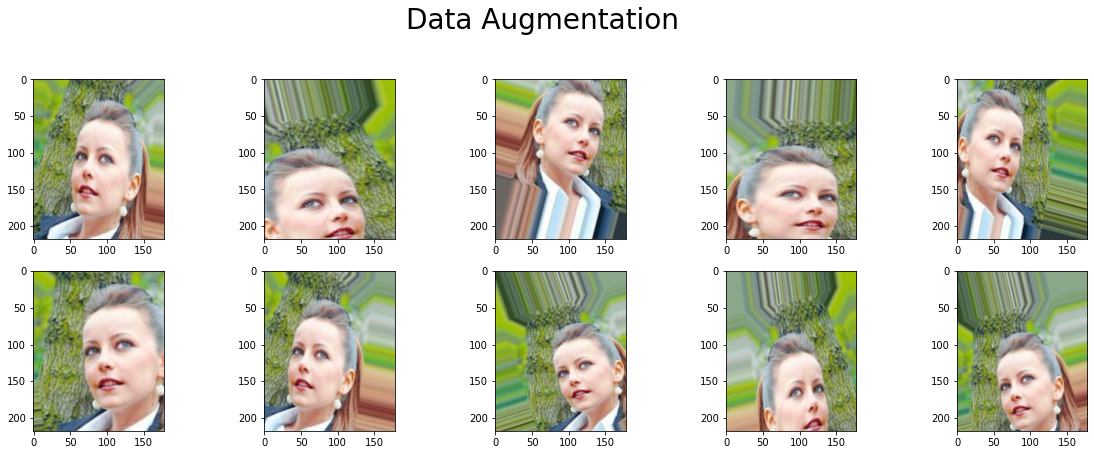

In [13]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=25,
  width_shift_range=0.25,
  height_shift_range=0.25,
  shear_range=0.25,
  zoom_range=0.25,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [14]:
# Generate the trainng, validationa and test data

# Train data
X_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=25,
  width_shift_range=0.25,
  height_shift_range=0.25,
  shear_range=0.25,
  zoom_range=0.25,
  horizontal_flip=True
)

train_datagen.fit(X_train)

train_generator = train_datagen.flow(
X_train, y_train,
batch_size=BATCH_SIZE,
)

# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLE)


In [24]:
X_train[0]

array([[[0.79607844, 0.75686276, 0.7607843 ],
        [0.79607844, 0.75686276, 0.7607843 ],
        [0.79607844, 0.75686276, 0.7607843 ],
        ...,
        [0.23529412, 0.21176471, 0.16470589],
        [0.22745098, 0.2       , 0.16078432],
        [0.22745098, 0.2       , 0.16078432]],

       [[0.79607844, 0.75686276, 0.7607843 ],
        [0.79607844, 0.75686276, 0.7607843 ],
        [0.79607844, 0.75686276, 0.7607843 ],
        ...,
        [0.22352941, 0.2       , 0.15294118],
        [0.22352941, 0.19607843, 0.15686275],
        [0.22352941, 0.19607843, 0.15686275]],

       [[0.79607844, 0.75686276, 0.7607843 ],
        [0.79607844, 0.75686276, 0.7607843 ],
        [0.79607844, 0.75686276, 0.7607843 ],
        ...,
        [0.21176471, 0.1882353 , 0.14117648],
        [0.21960784, 0.19215687, 0.15294118],
        [0.21960784, 0.19215687, 0.15294118]],

       ...,

       [[0.8784314 , 0.8352941 , 0.81960785],
        [0.8745098 , 0.83137256, 0.8156863 ],
        [0.8862745 , 0

## Build the model

In [15]:
# Import InceptionV3 Model
pre_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(pre_model.layers))
#inc_model.summary()

number of layers: 311


In [16]:
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 108, 88, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 108, 88, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 108, 88, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
# freeze the convolutional base
pre_model.trainable=False

In [18]:
pre_model.inputs

[<KerasTensor: shape=(None, 218, 178, 3) dtype=float32 (created by layer 'input_1')>]

In [19]:
# Adding custom layers

x = pre_model.output
x = GlobalAveragePooling2D()(x)
# 1024 as the GlobalAverage layer has halfed the 2048 in the mixed10 layer before
x = Dense(1024, activation='relu')(x)
# add Dropout layer
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)

# prediction activation is softmas because its a binary classification output
pred = Dense(2, activation ='softmax')(x)


In [20]:
# create the final model

# Model is directly imported from tf.keras
model = Model(inputs= pre_model.inputs, outputs=pred)

In [21]:
# compile the model

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              # Only two linear outputs so use BinaryCrossentropy and logits =True
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 108, 88, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 108, 88, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 108, 88, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 24, 19, 48)   12288       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 24, 19, 96)   55296       activation_15[0][0]              
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 24, 19, 48)   144         conv2d_13[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 24, 19, 96)   288         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 24, 19, 48)   0           batch_normalization_13[0][0]     
__________

## Train the Model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate((x_valid))

In [26]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=initial_epochs,
                    validation_data=(x_valid, y_valid)
                   )

Epoch 1/10
313/313 [==============================] - 545s 2s/step - loss: 0.1517 - accuracy: 0.9387 - val_loss: 0.1736 - val_accuracy: 0.9235
Epoch 2/10
313/313 [==============================] - 360s 1s/step - loss: 0.1405 - accuracy: 0.9437 - val_loss: 0.1602 - val_accuracy: 0.9380
Epoch 3/10
313/313 [==============================] - 304s 972ms/step - loss: 0.1339 - accuracy: 0.9466 - val_loss: 0.1584 - val_accuracy: 0.9315
Epoch 4/10
313/313 [==============================] - 335s 1s/step - loss: 0.1252 - accuracy: 0.9506 - val_loss: 0.1661 - val_accuracy: 0.9345
Epoch 5/10
313/313 [==============================] - 294s 941ms/step - loss: 0.1176 - accuracy: 0.9553 - val_loss: 0.1933 - val_accuracy: 0.9330
Epoch 6/10
313/313 [==============================] - 273s 873ms/step - loss: 0.1124 - accuracy: 0.9586 - val_loss: 0.1572 - val_accuracy: 0.9350
Epoch 7/10
313/313 [==============================] - 292s 931ms/step - loss: 0.1005 - accuracy: 0.9612 - val_loss: 0.1822 - val_accu

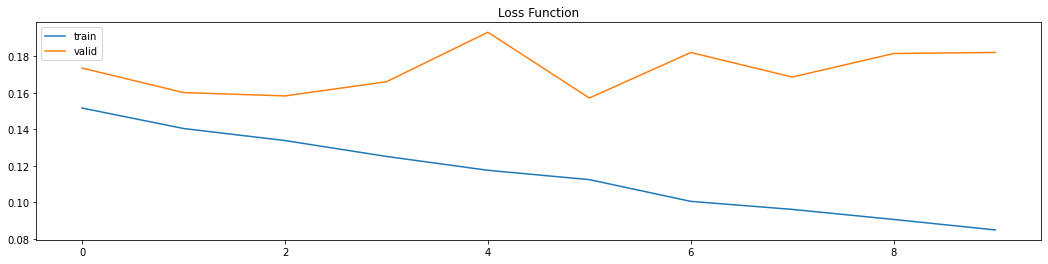

In [28]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

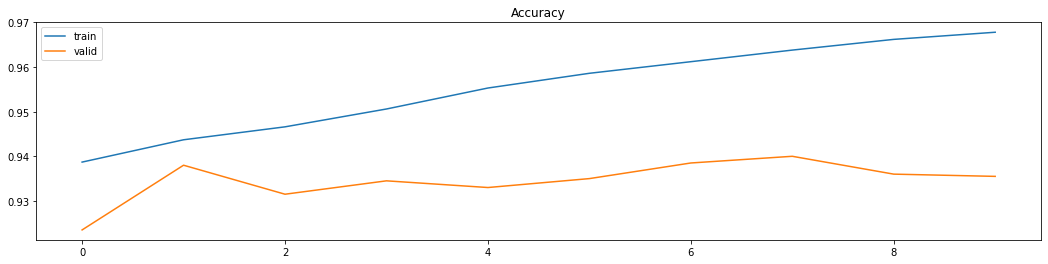

In [31]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()